# Algorithm of Build Graph

In [1]:
import torch
from core.model import MetaLearner

Load the Domain Knowledge

In [2]:
from domains.scene.objects_domain import objects_executor
domains = [objects_executor]

28 20:44:31 Function exists automatically registered.
28 20:44:31 Function forall automatically registered.
28 20:44:31 Function iota automatically registered.
28 20:44:31 Function negate automatically registered.
28 20:44:31 Function logic_and automatically registered.
28 20:44:31 Function logic_or automatically registered.
28 20:44:31 Function count automatically registered.
28 20:44:31 Function scene automatically registered.
28 20:44:31 Function red automatically registered.
28 20:44:31 Function green automatically registered.
28 20:44:31 Function blue automatically registered.
28 20:44:31 Function circle automatically registered.
28 20:44:31 Function rectangle automatically registered.
28 20:44:31 Function triangle automatically registered.
28 20:44:31 Function left automatically registered.
28 20:44:31 Function right automatically registered.


Create the MetaLearner

In [3]:
model = MetaLearner(domains, vocab = ["red", "object"])

28 20:44:31 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
28 20:44:31 WRN `RewriteExecutor` The input domain is empty, creating an empty domain


In [4]:
exprs = model.parse_display("red object", topK = 10)

expr, weight =  exprs[0]
print("expr:{}\nweight:{}".format(expr, weight))
expr = model.executor.parse_expression(str(expr))



metas = model.infer_metaphor_expressions(expr)
pass

print(metas)

forall:Objects(red:Objects(scene:Objects())), 0.15
forall:Objects(iota:Objects(scene:Objects())), 0.11
forall:Objects(blue:Objects(scene:Objects())), 0.10
negate:Objects(exists:Objects(scene:Objects())), 0.07
count:Objects(green:Objects(scene:Objects())), 0.04
count:Objects(iota:Objects(scene:Objects())), 0.04
count:Objects(scene:Objects()), 0.03
forall:Objects(scene:Objects()), 0.03
negate:Objects(forall:Objects(scene:Objects())), 0.03
forall:Objects(green:Objects(scene:Objects())), 0.03


expr:forall:Objects(red:Objects(scene:Objects()))
weight:-1.8690193891525269
[[]]


## Visualizer of the Rewrite Graph

In [5]:
from dataclasses import dataclass
from typing import Set, List, Tuple, Callable
from helchriss.dsl.dsl_values import Value
from helchriss.dsl.dsl_types import TypeBase
from core.model import MetaLearner
from core.metaphors.rewrite import NeuralRewriter, RewriteRule, Frame, pth_file
from core.metaphors.executor import RewriteExecutor
from helchriss.knowledge.executor import FunctionExecutor
from helchriss.knowledge.symbolic import Expression

import torch.nn as nn
import os

@dataclass
class SearchNode:
    """not the frame search node, the eval search node"""
    fn    : str               # executable fn on value
    value : List[Value]       # the value of the node, args of some function
    src   : None              # the source rewriter
    maintain : bool = None           # the virtual node
    next = []
    next_weights = []
    distr : None = None                    # the distribution value on the search node
    reachable : None  = None           # whether the node is reachable

from IPython.core.display import HTML

import networkx as nx

class SearchVisualizer:
    def __init__(self):
        self.query_trees = []
        self.active = 1

    def log(self, query_fn : str, args : List[Value], nodes : List[SearchNode], mode : str):
        if self.active:
            self.query_trees.append(
                (query_fn, args, nodes, mode)
            )

    def create_graph(self, nodes):
        graph = nx.DiGraph()

        def dfs(current_node: SearchNode):
            if current_node.value is None: current_node.value = []
            node_label = f"{current_node.fn}\n{[str(v.vtype) for v in current_node.value]}"
            node_label += f"\n{[str((torch.round(torch.tensor(v.value)*100)/100.).detach().numpy()) for v in current_node.value]}"
            graph.add_node(
            str(current_node),
            fn=current_node.fn,
            value=[v.value for v in current_node.value],
            label=node_label
            )
        
            for next_node, weight in zip(current_node.next, current_node.next_weights):
                dfs(next_node)
                graph.add_edge(str(current_node), str(next_node), weight=torch.tensor(weight).detach().numpy())

        dfs(nodes[0])

        return graph


In [ ]:

from helchriss.knowledge.symbolic import ConstantExpression, VariableExpression, FunctionApplicationExpression
from core.metaphors.executor import UnificationFailure
from helchriss.dsl.dsl_types import INT, FLOAT

def value_types(values : List[Value]): return [v.vtype for v in values]


class SearchExecutor(FunctionExecutor):
    """stores local rewrite frames then """
    def __init__(self, executor):
        super().__init__()
        self.base_executor : FunctionExecutor = executor
        self.rewrite_frames = nn.ModuleDict({}) # a bundle of rewriter rules that shares the same rewriter
        self.storage = SearchVisualizer()
        self.unification_p = 0.001
        self.supressed = 0

    """Save and Load Utils and Add Frames"""
    def save_ckpt(self, ckpt_path) -> int:
        if not os.path.exists(f"{ckpt_path}/frames"): os.makedirs(f"{ckpt_path}/frames")
        for frame_name in self.frames: torch.save(self.frames[frame_name], f"{ckpt_path}/frames/{frame_name}.pth")#.save_ckpt(f"{ckpt_path}/frames/{frame_name}")
        self.base_executor.save_ckpt(ckpt_path)
        return self

    def load_ckpt(self, ckpt_path) -> int:
        frames_dir = f"{ckpt_path}/frames"
        for filename in os.listdir(frames_dir):
            file_path = os.path.join(frames_dir, filename)
            if os.path.isfile(file_path) and pth_file(filename):
                self.frames[filename[:-4]] = torch.load(file_path, weights_only = False)
        self.base_executor.load_ckpt(ckpt_path)
        return self

    def add_frame(self,name : str, frame : Frame):
        """raw method of adding a frame to the dictionary"""
        self.rewrite_frames[name] = frame

    """Rewrite Search Graph Implementations"""
    def edges(self, node : SearchNode) -> List[SearchNode]:
        src_fn  = node.fn
        src_val = node.value
        src_tp  = value_types(src_val)
        nodes = []
        edges = []
        for key, frame in self.rewrite_frames.items():
            assert isinstance(frame, Frame), f"{frame} is not a `Frame`"

            if frame.source_type == src_tp:
                nxt_val, nxt_pr = frame.apply(src_val) # applied value and pr
                """enumerate matches that start with src_fn"""
                for fn_gn in frame.matches:
                    (fn, gn) = fn_gn.split("@")
                    if fn == src_fn:
                        fn_logit = frame.matches[fn_gn] # function match logit
                        nodes.append(SearchNode(gn, nxt_val, None))
                        edges.append(torch.sigmoid(nxt_pr + fn_logit))
        return nodes, edges

    def rewrite_search_tree(self, init_node : SearchNode,  max_iters = 100) :
        """graph start with value and end with fn by rewrites"""
        nodes : List[SearchNode] = []
        edges : List             = []

        #. start the bfs queue
        itrs = 0
        done = False
        queue : List[SearchNode] = [init_node]
        while not done:
            curr_node = queue.pop(0)
            frontier_nodes, frontier_edges = self.edges(curr_node)
            for node, edge_weight in zip(frontier_nodes, frontier_edges):
                # node is the nodes the curr_node connected ; edge is a weight
                assert isinstance(node, SearchNode), f"{node} not a search node"
                queue.append(node)
                curr_node.next.append(node)
                curr_node.next_weights.append(edge_weight)
                edges.append((curr_node, node, edge_weight))
            nodes.append(curr_node)
            itrs += 1
            done =  len(queue) == 0 or (itrs >= max_iters)
        return nodes
    
    def subtree_filter_target(self, init_node :SearchNode, nodes : List[SearchNode], target : str) -> List[SearchNode]:
        def dfs(node : SearchNode):
            node.maintain = 0
            for son in node.next:
                dfs(son)
                assert isinstance(son, SearchNode), f"{son} is not SearchNode"
                if son.maintain:
                    node.maintain = 1
                    break
            if node.fn == target: node.maintain = 1

        def subtree_select(node : SearchNode, df : int):
            if df: node.maintain = 1
            for son in node.next:
                assert isinstance(son, SearchNode), f"{son} is not SearchNode"
                if node.fn == target:
                    son.maintain = 1
                    subtree_select(son, 1)
        
        dfs(init_node) # select the parent of the target node
        subtree_select(init_node, 0) # select the whole subtree of the target node

        return [node for node in nodes if node.maintain == 1]

    def subtree_filter_margin(self, init_node : SearchNode, nodes : List[SearchNode], margin = 0.1):
        def dfs(node : SearchNode):
            for son, weight in zip(node.next, node.next_weights):
                assert isinstance(son, SearchNode)
                son.reachable = node.reachable * weight
                if son.reachable >= margin:
                    son.maintain = 1
                    dfs(son)
                else: son.maintain = 0
        init_node.reachable = 1.0
        dfs(init_node)
        subtree_nodes = [node for node in nodes]
        return subtree_nodes

    def rewrite_distr(self, value : List[Value], query_fn : str, mode = "eval") :
        """ return the rewrite paths from fn to target value
        Args:
            value : the input value to evaluate on
            fn    : the target fn to locate and evaluate
        Return:
            a distribution over search nodes
        """
        src_node = SearchNode("super_source", None, None, None, reachable = 1.)
        src_node.next = []
        src_node.next_weights = []
        rw_nodes : List[SearchNode] = [src_node]

        output_type = self.base_executor.function_signature(query_fn)[0][-1]
        functions = self.base_executor.gather_functions(value_types(value), output_type)
        for fn in functions:
            nd = SearchNode(fn, value, None)
            nd.next = []
            nd.next_weights = []
            subtree_nodes = self.rewrite_search_tree(nd)
            if mode == "eval": # select the subtree contains the query fn
                subtree_nodes = self.subtree_filter_target(subtree_nodes[0], subtree_nodes, query_fn)
            if mode == "update": # select the subtree that is reachable by margin
                subtree_nodes = self.subtree_filter_margin(subtree_nodes[0], subtree_nodes, margin = 0.01)
    
            if subtree_nodes: # not an empty subtree
                src_node.next.append(subtree_nodes[0]) # add the subtree head
                src_node.next_weights.append(1.)       # add the transition 1
                rw_nodes.extend(subtree_nodes)


        def dfs(node : SearchNode, success_reach):
            # the node is reachable and have no applicable rewrite.
            if node.next_weights:
                node.distr = node.reachable * (1. - torch.max(torch.tensor(node.next_weights)))
            else:
                node.distr = node.reachable
            for son, weight in zip(node.next, node.next_weights):
                assert isinstance(son, SearchNode)
                son.reachable = node.reachable * weight
                if son.fn == query_fn :
                    success_reach = max(success_reach, son.reachable)
                success_reach = max(success_reach,dfs(son, success_reach))
            return success_reach

        success_reach = dfs(src_node, 0.) # dfs on the super source node

        self.storage.log(query_fn, value, rw_nodes, mode)

        return [(node.fn, node.value, node.distr) for node in rw_nodes], success_reach

    def reduction_call(self, fn : str , args : List[Value]):
        """ evaluate the fn calls on the distribution over all possible rewrites
        start with the init_node that contains the value and the 
        1. locate each node that terminates, find the subtree that trace back to the init_node
        2. for the subtree, evaluate the expectation over the subtree distribution
        """        
        rewrite_pairs, success_reach = self.rewrite_distr(args, fn, mode = "eval")

        execute_pairs = rewrite_pairs[1:]
        if not isinstance(success_reach, torch.Tensor): success_reach = torch.tensor(success_reach)
        if success_reach < self.unification_p and not self.supressed:
            raise UnificationFailure(f"failed to unify {fn}({args}->{success_reach})", 
                                     left_structure = fn,
                                     right_structure = args)

        expect_output = 0.
        for (f, vargs, weight) in execute_pairs:
            measure : Value = self.base_executor.execute(f, vargs, grounding = self.grounding)

            if isinstance(measure.value, torch.Tensor) and (measure.vtype == INT or measure.vtype == FLOAT):

                expect_output += measure.value.reshape([-1])[0] * weight
            else:expect_output += measure.value * weight
        
        return Value(measure.vtype, expect_output), -torch.log(success_reach)

    """Evaluate Chain of Expressions"""
    def evaluate(self, expression, grounding):
        self.storage
        if not isinstance(expression, Expression):
            expression = self.parse_expression(expression)
        grounding = grounding if self._grounding is not None else grounding
        with self.with_grounding(grounding):
            outputs, loss = self._evaluate(expression)
        return outputs, loss
    
    def _evaluate(self, expr : Expression) -> Tuple[Value, str]:
        if isinstance(expr, FunctionApplicationExpression):
            # recusive call self.evaluate(arg) to evaluate the args in the subtree
            fn = expr.func.name
            args : List[Value] = []
            arg_loss  = []
            for arg in expr.args: 
                arg_value, subloss = self._evaluate(arg) # A List of Values
                args.append(arg_value)
                arg_loss.append(subloss)
            arg_types : List[TypeBase] = [arg.vtype for arg in args]
            
            output, loss = self.reduction_call(fn, args)
            return output, sum(arg_loss) + loss
        
        elif isinstance(expr, ConstantExpression):
            assert isinstance(expr.const, Value)
            return expr.const, 0.
        elif isinstance(expr, VariableExpression):
            assert isinstance(expr.name, Value)
            return expr.const, 0.
        else:
            raise NotImplementedError(f'Unknown expression type: {type(expr)}')
    

    """Update Search Rules and Purge/Merge Entries""" 
    def update_chain(self, args : List[Value], fn : str, topK = 4):
        """assert exist a path from the arg to the fn located space by some frames
        add frames and update fn on the margin types.
        Args:
            args : List[TypeBase] as the input arg types for the fn
            fn   : str as the input function name (specific to domain tag)
        """
        # 1. add rewriters that locate from the value node to the fn node.
        execute_pairs, reach_loss = self.rewrite_distr(args, fn, mode = "update")
        execute_pairs = execute_pairs[1:]

        # for each node that not in the 
        for (gn, vargs, weight) in execute_pairs:
            for (in_tps, out_tps) in self.base_executor.function_signature(fn):
  
                arg_types = value_types(vargs)

                src_tps = arg_types
                tgt_tps = in_tps 
    
                caster = infer_mlp_caster(src_tps, tgt_tps)
                learn0_frame = Frame(src_tps, tgt_tps, caster)
                #print(learn0_frame)
                learn0_frame.matches[(f"{gn}@{fn}")] = torch.tensor(0.)

                src_sig = 'x'.join([str(tp) for tp in src_tps])
                tgt_sig = 'x'.join([str(tp) for tp in tgt_tps])
                frame_sig = f"frame:{src_sig}->{tgt_sig}_"
                id_itr = 0
                done = 0
                while not done:
                    if (frame_sig + str(id_itr)) in self.rewrite_frames:id_itr += 1
                    else: done = 1
                print(f"{gn}@{fn} by",frame_sig + str(id_itr))
                self.rewrite_frames[frame_sig + str(id_itr)] = learn0_frame

        # 2. add the filler that defined on the value node.

        return self
    
    def purge_frames(self, p = 0.1):
        """purge the the last p percent of all the newly added connection
        the last p percent of the newly added frames need to be removed.
        Args:
            p : the percent of newly added frames needed to be removed
        """
        return self
    
    def merge_frames(self, p = 0.1):
        """merge frames that shares the     same rewriter, distinguish rewriter using subsets of data
        Args:
            p : the metric of how close two rewriter need to be merged together
        merge two frames with shared rewriter and combine the 
        """
        return self

from core.metaphors.types import RuleBasedTransformInferer, infer_mlp_caster
from core.metaphors.executor import ExecutorGroup
from domains.scene.objects_domain import objects_executor
from domains.spatial.direction_domain import direction_executor
from domains.math.integer_domain import integer_executor
from domains.structure.path_domain import path_executor


executor_group = ExecutorGroup([\
    objects_executor,
    direction_executor,
    integer_executor,
    path_executor])
executor = SearchExecutor(executor_group)

## path1 plus path2
## failed to rewrite from ?f pathxpath -> plus ?x?y->int
## create new function plus pathxpath ->

## path1 connect to path2

## scene inputs are dynamical

out = executor.evaluate("minus:Integer(one:Integer(), two:Integer())", {})

query = "east:Direction(one:Integer(), two:Integer())"

try:
    out = executor.evaluate(query, {})
except UnificationFailure as ue:
    query_fn = ue.left_structure
    value = ue.right_structure
    executor.update_chain(value, query_fn)
    print("update chain")
    print(ue)
    out = executor.evaluate(query, {})
out = executor.evaluate(query, {})
print(out)


28 20:44:31 Function north automatically registered.
28 20:44:31 Function south automatically registered.
28 20:44:31 Function east automatically registered.
28 20:44:31 Function west automatically registered.
28 20:44:31 Function northeast automatically registered.
28 20:44:31 Function northwest automatically registered.
28 20:44:31 Function southeast automatically registered.
28 20:44:31 Function southwest automatically registered.
28 20:44:31 Function one automatically registered.
28 20:44:31 Function two automatically registered.
28 20:44:31 Function three automatically registered.
28 20:44:31 Function plus automatically registered.
28 20:44:31 Function minus automatically registered.
28 20:44:31 Function avg automatically registered.
28 20:44:31 Function smaller automatically registered.
28 20:44:31 Function bigger automatically registered.
28 20:44:31 Function N automatically registered.
28 20:44:31 Function Z automatically registered.
28 20:44:31 Function subset automatically re

smaller:Integer@east:Direction by frame:floatxfloat->Vector[float,2]xVector[float,2]_0
bigger:Integer@east:Direction by frame:floatxfloat->Vector[float,2]xVector[float,2]_1
update chain
failed to unify east:Direction([Value:[1.0000]-float P:[1.0], Value:[2.0000]-float P:[1.0]]->0.0)
Left structure: east:Direction
Right structure: [Value:[1.0000]-float P:[1.0], Value:[2.0000]-float P:[1.0]]
(Value:[-6.8154]-bool P:[1.0], tensor(0.6593, grad_fn=<AddBackward0>))


In [7]:

optim = torch.optim.Adam(executor.parameters(), lr = 1e-2)
executor.supressed = 1
for epoch in range(30):
    out, inherent_loss = executor.evaluate(query, {})
    loss = 0.
    loss = torch.nn.functional.binary_cross_entropy(torch.sigmoid(out.value), torch.tensor(1.))
    loss += inherent_loss

    loss.backward()
    optim.step()

out = executor.evaluate(query, {})

print(out)

(Value:[5.5170]-bool P:[1.0], tensor(0.2154, grad_fn=<AddBackward0>))


In [8]:
def tree_layout(tree, root=None):
    if root is None:
        root = next(iter(tree.nodes))  # Assume first node is root
    
    # Compute depth (level) of each node
    depths = {root: 0}
    queue = [root]
    while queue:
        node = queue.pop(0)
        for child in tree.neighbors(node):
            if child not in depths:
                depths[child] = depths[node] + 1
                queue.append(child)
    
    # Group nodes by depth
    levels = {}
    for node, depth in depths.items():
        levels.setdefault(depth, []).append(node)
    
    # Assign positions: x = index in level, y = -depth (top-down)
    pos = {}
    for depth, nodes in levels.items():
        for i, node in enumerate(nodes):
            pos[node] = (i, -depth)  # Negative y for top-down layout
    return pos


In [9]:
import matplotlib.pyplot as plt
import networkx as nx
def visualize_graph(graph: nx.DiGraph):

    #pos = nx.shell_layout(graph)
    pos = nx.spring_layout(graph, seed=42, iterations=50, weight='weight', k=0.3)
    pos = nx.kamada_kawai_layout(graph, scale=2)
    pos = tree_layout(graph)

    nx.draw_networkx_nodes(graph, pos, node_size=500, node_color='lightblue')
    

    labels = nx.get_node_attributes(graph, 'label')
    nx.draw_networkx_labels(graph, pos, labels, font_size=8)
    

    nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), arrowstyle='->', width=2)
    edge_weights = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_weights, font_size=6)
    
    plt.title("DFS")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

[SearchNode(fn='super_source', value=None, src=None, maintain=None, distr=tensor(0.), reachable=1.0), SearchNode(fn='one:Integer', value=[], src=None, maintain=1, distr=1.0, reachable=1.0)]
106
DiGraph with 5 nodes and 4 edges


/var/folders/ms/qbhhrxd119555wkjspljcjcc0000gn/T/ipykernel_26440/1329165837.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_label += f"\n{[str((torch.round(torch.tensor(v.value)*100)/100.).detach().numpy()) for v in current_node.value]}"
/var/folders/ms/qbhhrxd119555wkjspljcjcc0000gn/T/ipykernel_26440/1329165837.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  graph.add_edge(str(current_node), str(next_node), weight=torch.tensor(weight).detach().numpy())


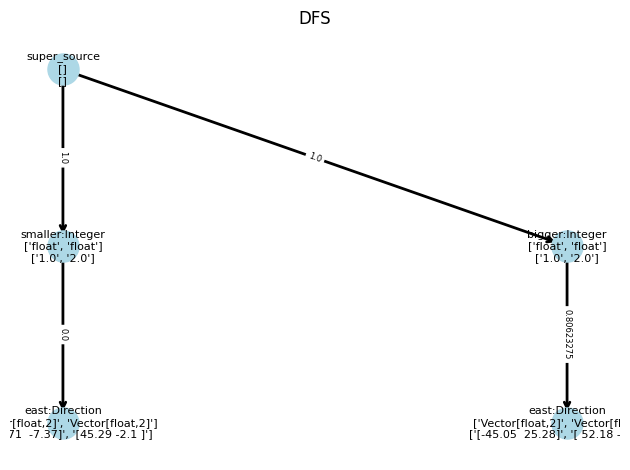

In [20]:
trees = executor.storage.query_trees

print(trees[0][2])
print(len(trees))
graph = executor.storage.create_graph(trees[-1][2])

print(graph)
visualize_graph(graph)